# **Makine Öğrenimi ile Stres Tespiti**

***Makine Öğrenimi ile Stres Tespiti***

Bu görev için kullandığım veri kümesi, ruh sağlığı ile ilgili subredditlerde yayınlanan verileri içeriyor. Bu veri kümesi, insanların yaşamları hakkında paylaştıkları çeşitli ruh sağlığı sorunlarını içermektedir. Neyse ki, bu veri kümesi 0 ve 1 olarak etiketlenmiştir, burada 0 stres olmadığını ve 1 stresi gösterir. Bu yüzden aşağıdaki bölümde, Python kullanarak sosyal medya gönderilerinde stres algılama görevini size anlatacağım.

Bu veri kümesi, insanların yaşamları hakkında paylaştıkları çeşitli ruh sağlığı sorunlarını içermektedir. Neyse ki, bu veri kümesi 0 ve 1 olarak etiketlenmiştir, burada 0 stres olmadığını ve 1 stresi gösterir. Bu yüzden aşağıdaki bölümde, Python kullanarak sosyal medya gönderilerinde stres algılama görevini size anlatacağım.

***Python Kullanarak Stres Tespiti***

Şimdi makine öğrenimi ile stres algılama görevine başlayalım. Bu göreve gerekli Python kütüphanelerini ve bu görev için ihtiyacımız olan [veri kümesini](https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv) içe aktararak başlayacağım:

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv")
print(data.head())

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555       

*Bu veri kümesinin herhangi bir null değer içerip içermediğine bir göz atalım:*



In [2]:
print(data.isnull().sum())

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


*Dolayısıyla bu veri kümesinde boş değer yoktur. Şimdi bu veri kümesinin metin sütununu stopword'ler, bağlantılar, özel semboller ve dil hataları ile temizlemek için hazırlayalım:*

In [3]:
import nltk
import re 
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword = set(stopwords.words('english'))

def clean(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = [word for word in text.split(' ') if word not in stopword]
  text = " ".join(text)
  text = [stemmer.stem(word) for word in text.split(' ')]
  text = " ".join(text)
  return text
data["text"] = data["text"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Şimdi metin sütununun kelime bulutunu görselleştirerek sosyal medyada yaşam sorunlarını paylaşan kişilerin en çok kullandıkları kelimelere bir göz atalım:*

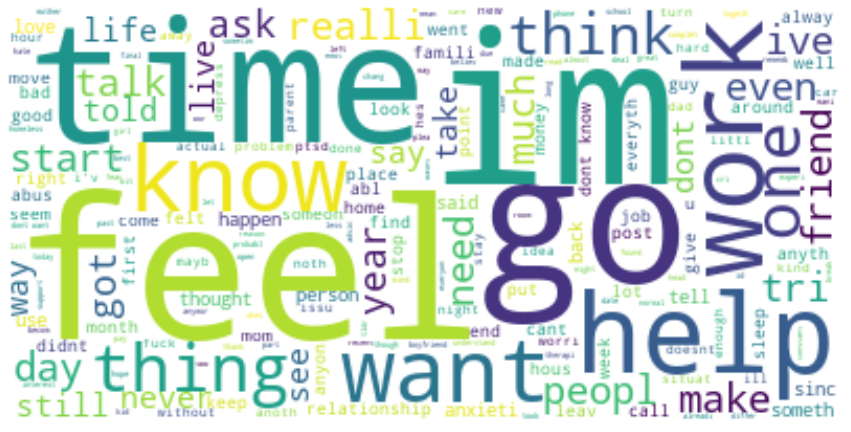

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Stres Tespit Modeli**

***Bu veri kümesindeki etiket sütunu 0 ve 1 etiketlerini içerir. 0 stres yok, 1 ise stres anlamına gelir. Ben 1 ve 0 yerine Stress ve No stress etiketlerini kullanacağım. Bu sütunu buna göre hazırlayalım ve bir makine öğrenimi modelini eğitme işlemi için metin ve etiket sütunlarını seçelim:***

In [5]:
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})
data = data[["text", "label"]]
print(data.head())

                                                text      label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe  im curr...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


***Şimdi bu veri kümesini eğitim ve test kümelerine ayıracağım:***

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x = np.array(data["text"])
y = np.array(data["label"])

cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y,
                                                test_size=0.33,
                                                random_state=42)

***Bu görev ikili sınıflandırma problemine dayandığından, ikili sınıflandırma problemleri için en iyi algoritmalardan biri olan Bernoulli Naive Bayes algoritmasını kullanacağım. Şimdi stres algılama modelini eğitelim:***


In [7]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

***Şimdi modelimizin performansını ruh sağlığına dayalı bazı rastgele cümleler üzerinde test edelim:***

In [8]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: People need to take care of their mental health
['No Stress']


In [9]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: Sometime I feel like I need some help
['Stress']


# **Özet**

***Sosyal medya paylaşımlarından stresi tespit etmek için bir makine öğrenimi modelini bu şekilde eğitebilirsiniz. İnsanlar duygularını genellikle sosyal medya platformlarında paylaşır. Birçok kuruluş, hangi sosyal medya kullanıcılarının stresli olduğunu bulmak ve onlara hızlı bir şekilde yardımcı olmak için stres tespitini kullanabilir.***